# Linear Programming exercise

In [1]:
### Do the imports -- no need to change this
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
sys.path.insert(0, "src/")
from environment import GridWorldEnvironment
from MDPsolver import MDPsolver
from utils import *
from plot import *
%load_ext autoreload
%autoreload 2

***Before starting, we recall the use of the gridworld environment.***

The gridworld environment is instantiated via the class `GridWorldEnvironment`. 

***It takes 4 input values:***
- `reward_mode` : Integer between 0 and 3 for different reward profiles,
- `size`: Gridworld size,
- `prop`: Probability assigned to the event that the agent does not follow the chosen action but another one selected uniformely at random,
- `gamma`: Discount factor of the environment.

***Interface of a Gridworld instance:***
- `print(gridworld.n_states)` # return the number of states
- `print(gridworld.n_actions)` # return the number of actions
- `print(gridworld.r)` # return a matrix where each element indicates the reward corresponding to each (state, action) pair.
- `print(gridworld.gamma)` # return the discount factor
- `print(gridworld.sparseT[action])` # Input: action, Return: a matrix containing the state-to-state transition probabilities for the action passed as input.

<img src="src/vis_gridworld.png" alt="fishy" class="bg-primary" width="400px">

In [3]:
reward_mode = 2 # see below to visualize the reward function
size = 3 # size of the gridworld (3x3)
prop = 0.1 # proportion of randomly taken steps due to noise in the environment 
gamma=0.99 # discount factor

gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)
print('Reward function: \n', gridworld.r) # visualize the reward function

Reward function: 
 [[   0.    0.    0.    0.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]
 [-100. -100. -100. -100.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]]


We will use a solver to compute the **optimal value function** to measure the suboptimality of the policies produced by our algorithms.

To access the optimal value function use `solver.v`.

In [4]:
solver = MDPsolver(gridworld) # call the MDPsolver class
solver.value_iteration() # call the value iteration method to find V^* once

## Ex 1: Solving the Primal [20 points]

We will leverage the powerful `scipy` library to solve **Linear Programs (LPs)**. Below we give an example of using the [linprog module](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html) to solve a simple LP:

\begin{aligned}
 & \min_{x := \begin{bmatrix}
x_0  \\
x_1
\end{bmatrix}  \in \mathbb{R}^2}  \begin{bmatrix}
-1  \\
4
\end{bmatrix} ^\top x
\\&  \text{s.t.}  \begin{bmatrix}
-3 & 1 \\
1 & 2 
\end{bmatrix} \mathbb{x} \le  \begin{bmatrix}
6  \\
4 
\end{bmatrix} , \quad  x_1\ge -3 \,.
\end{aligned}

The **code example below will be instructive** when you later construct the LP corresponding to the MDP.

In [ ]:
from scipy.optimize import linprog # import the linear programming solver (linprog) from scipy

# Note that the bounds argument in linprog is a  sequence of (min, max) pairs for each element in x, defining the minimum and maximum values.
x0_bounds = (None, None)
x1_bounds = (-3, None)

# call linear programming solver:
res = linprog([-1, 4], 
              A_ub=[[-3, 1], [1, 2]], 
              b_ub=[6, 4], 
              bounds=[x0_bounds, x1_bounds],
              method="simplex")
print('The solution is ', res.x) # access and print the solution
print(res.message) # print the message of the solver (e.g., terminated successfully)

The solution is  [10. -3.]
Optimization terminated successfully.


/var/folders/qb/0x3tn4t54299rywnp95tcyvh0000gn/T/ipykernel_27516/2674117054.py:8: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog([-1, 4],


Now we are ready to use `linprog` to solve the LP problem in gridworld.

We define a distribution `mu` over the states.

In [6]:
mu = np.ones((gridworld.n_states,1))/gridworld.n_states # initialize mu

Next, we need to **instantiate the constraints of the primal problem**. Notice that `scipy` requires the inequality constraints in the form $A_{ub} x \leq b_{ub}$.


To this end, we rewrite the constraint $EV \geq \gamma P V + r$ in the form expected by `scipy`.

In [7]:
def build_matrix(env):
    E = np.kron(np.eye(env.n_states), np.ones(env.n_actions)).T # build the matrix E
    P = env.T.transpose((1,0,2)).reshape(env.n_states*env.n_actions, -1) # build the matrix P
    return env.gamma*P - E

(Side remark: The indexing in the matrices `E` and `P` here is slightly different from the one in the lecture. This does not change any of the formulas from the slides since both matrices are indexed in the same way, consistently throughout this exercise. You may ignore this comment.)

Then, use the function `linprog` of `scipy` to solve the dual problem and show that you can retrieve the same $V^\star$ computed with the solver and stored in `solver.v`

In [8]:
# Call linear programming solver with the correct inputs:
primal_out = linprog(c=mu.flatten(), 
                     A_ub=build_matrix(gridworld), 
                     b_ub= np.zeros(gridworld.n_states*gridworld.n_actions),
                     method="simplex",
                     bounds=(0, None))

/var/folders/qb/0x3tn4t54299rywnp95tcyvh0000gn/T/ipykernel_27516/896455224.py:2: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  primal_out = linprog(c=mu.flatten(),


(*Hint:* Check slide 23 for the matrix form (or slide 8), lecture 3 to recall the primal.)

We can access the solution of the primal LP using `primal_out.x`. Compare the error with the value of `solver.v`.

In [9]:
np.linalg.norm(primal_out.x - solver.v) # plot 2-norm

101.20311275993046

***Question***

By running the following two cells, plot (in matrix form) `mu` and the difference between `solver.v` and `primal_out.x`. Then, answer the following question: Can we ensure that `np.linalg.norm(primal_out.x - solver.v)` is zero (up to numerical errors) for the current value of `mu`?  

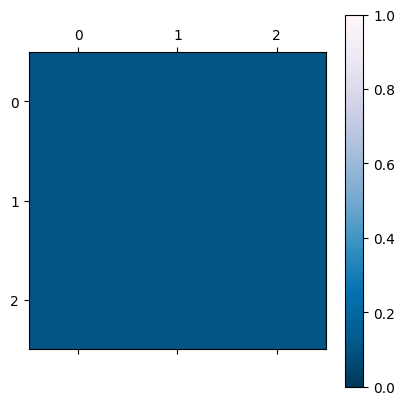

In [10]:
plt.matshow(mu.reshape(size, size), cmap='PuBu_r', vmin=0,vmax=1) # plot distribution mu over states 
plt.colorbar()

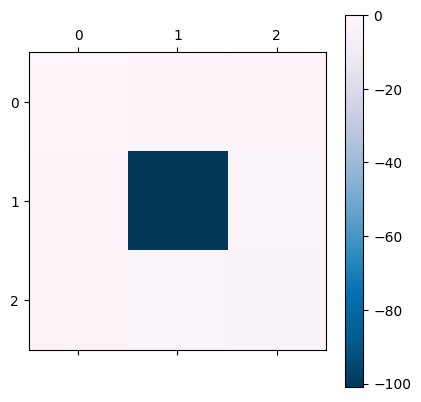

In [11]:
plt.matshow((solver.v - primal_out.x).reshape(size, size), cmap='PuBu_r') # plot the difference between the value function and the solution of the linear program
plt.colorbar()

**Answer**

Yes, in theory the LP solution and $V_t$ should match (up to small numerical errors) when $\mu$ is uniform. The primal LP enforces the Bellman optimality constraints for all states, so the minimal feasible solution is $V_t$. Any large discrepancy is likely due to numerical or implementation issues.

Next, we repeat the same experiment with a different value of `mu`. 

Note that we do **not** overwrite `mu` or `primal_out` (but instead have `mu2` and `primal_out2`, since for all other exercises, we will use the original, uniform `mu`.)

In [12]:
# overwrite mu with a new distribution:
mu2 = np.zeros((gridworld.n_states,1))
mu2[-3] = 1

Fill in the following, as before but for the distribution `mu2`.

In [13]:
# solve the LP with the new mu2:
primal_out2 = linprog(c=mu2.flatten(), 
                      A_ub=build_matrix(gridworld), 
                      b_ub=np.zeros(gridworld.n_states*gridworld.n_actions),
                      method="simplex",
                      bounds=(0, None))

/var/folders/qb/0x3tn4t54299rywnp95tcyvh0000gn/T/ipykernel_27516/3909383837.py:2: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  primal_out2 = linprog(c=mu2.flatten(),


We compare with the value computed by Value Iteration `solver.v`.

In [14]:
np.linalg.norm(primal_out2.x - solver.v) # plot 2-norm

101.20311275993046

Note that now, the optimal solution of the primal LP `primal_out2.x` and the optimal value function `solver.v` do not coincide anymore! 

This is despite the fact that the optimal value function `solver.v` was computed **right in the beginning**, before we even initialized the `mu` for solving the LP the first time. So `solver.v` is definitely the correct optimal value function for each state.

**Question:**

Why does it make sense that the two values do not coincide?

**Answer:**

When using a non-uniform distribution (like $\mu_2$, which puts all mass on one state), the LP objective only penalizes errors in that state. In states where $\mu_2 = 0$, the objective is indifferent to the values, so the LP solution can differ from $V_t$. This is why $\|primal\_out2.x - V_t\|$ is large.

***Question***

We plot again in matrix form `mu2`, `solver.v` and `primal_out2.x`. Then answer the following: What can happen in the states where `mu2 = 0`?

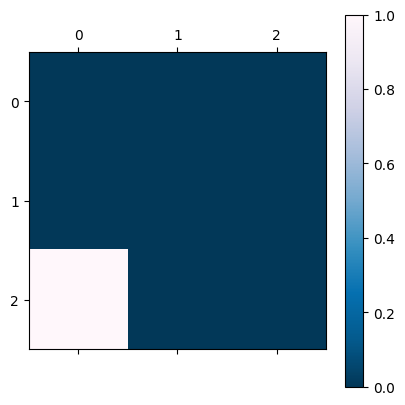

In [15]:
plt.matshow(mu2.reshape(size, size), cmap='PuBu_r', vmin=0,vmax=1) # plot distribution mu over states
plt.colorbar()

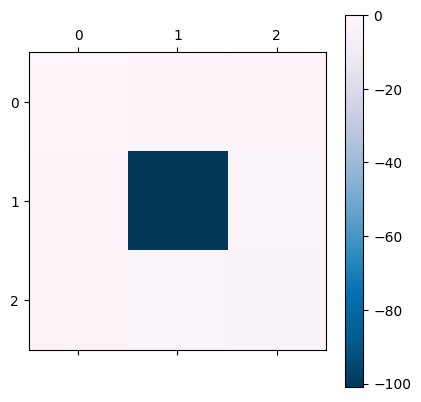

In [16]:
plt.matshow((solver.v - primal_out2.x).reshape(size, size), cmap='PuBu_r') # plot the difference between the value function and the solution of the linear program
plt.colorbar()

**Answer:**

In states where $\mu_2 = 0$, the LP objective does not penalize the value, so the solution can deviate from $V_t$ without increasing the cost. As a result, those states' values may be arbitrary (within the feasibility constraints) and can differ significantly from the optimal $V_t$.

# Ex 2: Solving the Dual [20 points]

Try now to solve the dual using again the `linprog` routine of scipy. 

Note that we did **not** overwrite `mu` (i.e. it is still uniform, and `primal_out.x` is the primal solution for this `mu`).

(*Hint:* Check slide 23 for the matrix form (or slide 11), lecture 3 to recall the dual.)

In [17]:
# solve the dual LP with the correct inputs:
dual_out = linprog(c=gridworld.r.reshape(-1), 
              A_eq=(-build_matrix(gridworld)).T,
              b_eq= -(1 - gridworld.gamma)*mu,
              method="simplex",
              bounds=(0, None))

/var/folders/qb/0x3tn4t54299rywnp95tcyvh0000gn/T/ipykernel_27516/4198367224.py:2: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  dual_out = linprog(c=gridworld.r.reshape(-1),


We verify that **strong duality** holds:

In [18]:
dual_value = dual_out.x.dot(gridworld.r.reshape(gridworld.n_states*gridworld.n_actions)) # compute the optimal value of the dual
primal_value = (1 - gridworld.gamma)*primal_out.x.dot(mu)[0] # compute the optimal value of the primal
abs(primal_value - dual_value) # print the absolute difference between the primal and dual optimum

0.0

Note that the solution of the dual problem gives us the **optimal occupancy measure**. Given this:

1. Obtain the **greedy policy** given the solution of the primal problem.

2. **Evaluate** this policy and **compare** the obtained values with the solution of the dual problem.

In [19]:
def evaluate_policy(pi, env, tol=1e-10):
    """Implementation of policy evaluation through iteratively applying using a certain policy 
    Args:
        pi: a policy
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        v: an array with the values of the actions chosen
        q: an array with the q values    
    """
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    while True:
        v_old = np.copy(v)
        for a in range(env.n_actions):
            q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v)
        for s in range(env.n_states):
            action_taken = pi[s]
            v[s] = q[s,action_taken]
        if np.linalg.norm(v - v_old) < tol:
            break
    return v, q

In [20]:
pi = dual_out.x.reshape(gridworld.n_states,gridworld.n_actions).argmax(axis=1) # side remark/explanation: We know a deterministic optimal policy exists. It turns out that we can find it by checking for which component a lambda_opt(s,a) is > 0, and then setting pi_opt(a|s) = 1 for that action.
v,q = evaluate_policy(pi,gridworld) # evaluate the policy
print(np.linalg.norm(v-primal_out.x)) # print the 2-norm between the value function and the solution of the primal LP

344.69395148973746


***Questions***

Derive the dual from the primal. That is, show that it indeed the dual linear program of the primal program (and that thus the values coincide by strong duality).

(*Hint:* You may consult the supplementary material of lecture 3, slide 9 and 10 in the appendix to read about strong duality in LPs. Make sure to explain step by step why it works.)

**Answer**

We start with the primal LP (using standard notation):

$$
\begin{aligned}
\text{minimize } & (1-\gamma)\,\langle \mu, V_t \rangle \\
\text{subject to } & V_t(s) \ge r(s,a) + \gamma\sum_{s'} p(s' \mid s,a)\,V_t(s'),\quad \forall s,a.
\end{aligned}
$$

1. **Rewrite in Standard Form:**  
   Rewrite the constraint as  
   $$
   V_t(s) - \gamma\sum_{s'} p(s' \mid s,a)\,V_t(s') \ge r(s,a),
   $$
   which can be expressed for each action $a$ as  
   $$
   [I - \gamma P^a]\,V_t \ge r^a.
   $$
   Collecting these constraints for all states and actions, we obtain  
   $$
   -(E - \gamma P)\,V_t \le -r,
   $$
   where $E$ is an operator that repeats $V_t(s)$ for every action and $r$ is the reward vector.

2. **Form the Lagrangian:**  
   Let $\lambda(s,a) \ge 0$ be the dual variable for each constraint. Then, the Lagrangian is
   $$
   \mathcal{L}(V_t, \lambda) = (1-\gamma)\,\langle \mu, V_t \rangle + \sum_{s,a} \lambda(s,a) \Bigl[ r(s,a) - \Bigl(V_t(s) - \gamma\sum_{s'} p(s'\mid s,a)V_t(s')\Bigr) \Bigr].
   $$

3. **Group the $V_t$ Terms:**  
   Rearranging, we have
   $$
   \mathcal{L}(V_t, \lambda) = \sum_{s,a}\lambda(s,a)\,r(s,a) + \sum_{s}V_t(s)\Bigl[(1-\gamma)\mu(s) - \sum_{a}\lambda(s,a) + \gamma\sum_{s,a} p(s'\mid s,a)\,\lambda(s,a)\Bigr].
   $$
   Minimizing over $V_t$ forces the coefficient of $V_t(s)$ to be zero for every $s$, i.e.,
   $$
   (1-\gamma)\mu(s) + \gamma \sum_{s,a} p(s'\mid s,a)\,\lambda(s,a) = \sum_{a}\lambda(s,a) \quad \text{for all } s.
   $$

4. **Dual LP Formation:**  
   This condition can be written in compact form as
   $$
   (E - \gamma P)^\top \lambda = (1-\gamma)\mu.
   $$
   Substituting back into the Lagrangian, the dual LP becomes
   $$
   \max_{\lambda \ge 0} \sum_{s,a}\lambda(s,a)\,r(s,a) \quad \text{subject to} \quad (E - \gamma P)^\top \lambda = (1-\gamma)\mu.
   $$

5. **Strong Duality:**  
   Under standard feasibility conditions, strong duality holds for linear programs. This means that the optimal value of the primal LP equals the optimal value of the dual LP. As a result, the occupancy measure derived from the dual provides a performance cost equal to that of the primal, ensuring that the two formulations yield the same optimal value.

Thus, we have derived the dual LP from the primal and demonstrated that their optimal values coincide by strong duality.

# Ex 3: Implement REPS with known dynamics [20 points]

In this exercize you will **implement the REPS algorithm** as we have seen in the lectures.
Namely, recall the following **details of the algorithm**:

1. **Initialization** (uniform): $\forall s, a, \lambda_0(s,a) = \frac{1}{|\mathcal{S}||\mathcal{A}|}$;

2. **REPS loss computation**: $\mathcal{L}(\lambda, V) = (1-\gamma) \langle \mu, V \rangle + \frac{1}{\eta}\log{\langle \lambda, \exp{(\eta(r+\gamma P V - E V))} \rangle}$;

3. **Solving for the values**: $V_{k}=\text{argmin}_{V}~{\mathcal{L}(\lambda_k, V)}$, for this we will use the `minimize` function from `scipy.optimize`;

4. **Updating the occupancy measure:** $\lambda_{k+1} \propto \lambda_k \cdot \exp{(\eta (r+\gamma P V_{k} - E V_{k}))}$ (unnormalized, you then must make sure it sums to 1 in every step).

In [21]:
from scipy.optimize import minimize
from scipy.special import logsumexp, softmax
from plot import plot_log_lines, plot_lines

In [22]:
def reps_loss(lambda_, V, eta, initial): # return the reps loss
    term1 = (1 - gridworld.gamma) * np.dot(initial.flatten(), V)
    delta = gridworld.r.reshape(-1) + build_matrix(gridworld).dot(V)
    term2 = (1 / eta) * logsumexp(np.log(lambda_) + eta * delta)
    return term1 + term2

def minimize_reps_loss(lambda_, eta, initial): # find minimizer of the reps loss
    loss = lambda V : reps_loss(lambda_, V, eta, initial)
    V = minimize(loss, np.zeros(gridworld.n_states), method = "CG", options={'maxiter': 1000})
    return V.x

In [23]:
K = 40 # number of iterations
mu = np.ones((gridworld.n_states,1))/gridworld.n_states # initialize mu again to the uniform distribution (not needed, just to be safe)

#initialize the variables
subopts = []
feasibility_errors = []
lambda_ = np.ones(gridworld.n_states*gridworld.n_actions)/gridworld.n_states/gridworld.n_actions
iterates = [lambda_]
subopts.append(-lambda_.T.dot(gridworld.r.reshape(gridworld.n_states*gridworld.n_actions))+(1-gridworld.gamma)*mu.T.dot(solver.v)[0])
feasibility_error = np.linalg.norm(build_matrix(gridworld).T.dot(lambda_) + (1-gridworld.gamma)*mu)
feasibility_errors.append(feasibility_error)

# REPS: iterate over K steps
for k in range(K):
    eta = 1/np.sqrt(k+1) # set the step size
    
    V = minimize_reps_loss(lambda_, eta, mu) # minimize the reps loss
    delta = gridworld.r.reshape(gridworld.n_states*gridworld.n_actions) + build_matrix(gridworld).dot(V) # compute the advantage function
    
    new_lambda_ = lambda_ * np.exp(eta * delta) # update the lambda
    new_lambda_ /= np.sum(new_lambda_) # normalize the lambda_
    lambda_ = new_lambda_
    
    # store the suboptimality and feasibility errors:
    subopt = -lambda_.T.dot(gridworld.r.reshape(gridworld.n_states*gridworld.n_actions))+(1-gridworld.gamma)*mu.T.dot(solver.v)[0]
    feasibility_error = np.linalg.norm(build_matrix(gridworld).T.dot(lambda_) + (1-gridworld.gamma)*mu)
    subopts.append(subopt)
    feasibility_errors.append(feasibility_error)
    iterates.append(lambda_)

**Plot of the suboptimality of iterates produced by REPS**

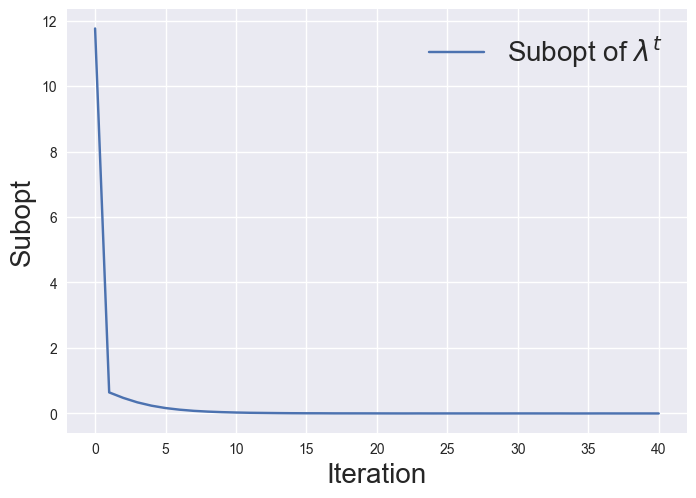

In [24]:
plot_lines([np.array(subopts)], [r"Subopt of $\lambda^t$"], ["Iteration", "Subopt"], "figs", "subopts.pdf", show = True)

**Theoretical Derivation of REPS**

Prove that the iterates of REPS are equivalent to the iterates produced by the following updates:

$$ \lambda_{k+1} = \mathrm{argmax}_{\lambda} \left( \langle \lambda, r \rangle - \frac{1}{\eta} \left\langle \lambda,~ \log\left(\frac{\lambda}{\lambda_k}\right) \right\rangle \right) \quad \text{s.t.} \quad E^T \lambda = \gamma P^T \lambda + (1 - \gamma) \mu. $$

(*Hint:* Check the slides of lecture if you do not know where to start.)

**Answer:**

We can derive the REPS update by considering a regularized optimization step on the occupancy measure. In particular, we start from the dual view of the MDP, where we wish to maximize the expected reward while satisfying the feasibility constraint
$$
E^T\lambda = \gamma P^T\lambda + (1-\gamma)\mu.
$$

To prevent drastic changes from one iteration to the next, we add a relative entropy (KL divergence) regularizer that penalizes the deviation of $\lambda$ from the previous iterate $\lambda_k$. This leads to the following optimization problem:
$$
\lambda_{k+1} = \operatorname{argmax}_{\lambda \ge 0} \Biggl\{ \langle \lambda, r \rangle - \frac{1}{\eta} \sum_{s,a} \lambda(s,a) \log\frac{\lambda(s,a)}{\lambda_k(s,a)} \Biggr\} \quad \text{s.t.} \quad E^T\lambda = \gamma P^T\lambda + (1-\gamma)\mu.
$$

The derivation proceeds as follows:

1. **Regularized Objective:**  
   We wish to improve the expected reward while staying close to $\lambda_k$. This is achieved by optimizing
   $$
   \langle \lambda, r \rangle - \frac{1}{\eta} D_{\mathrm{KL}}(\lambda\|\lambda_k),
   $$
   where
   $$
   D_{\mathrm{KL}}(\lambda\|\lambda_k) = \sum_{s,a} \lambda(s,a) \log\frac{\lambda(s,a)}{\lambda_k(s,a)}.
   $$

2. **Mirror Descent Interpretation:**  
   This formulation is equivalent to a mirror descent step (with the KL divergence as the Bregman divergence) in the space of occupancy measures. The resulting update takes the form
   $$
   \lambda_{k+1}(s,a) \propto \lambda_k(s,a)\exp\bigl(\eta\,r(s,a)\bigr),
   $$
   with additional modifications introduced by the Bellman residual term (involving $\gamma P V_k$ and $EV_k$) when the full MDP dynamics are taken into account.

3. **Enforcing Feasibility:**  
   The constraint
   $$
   E^T\lambda = \gamma P^T\lambda + (1-\gamma)\mu
   $$
   ensures that the updated $\lambda$ remains a valid occupancy measure. When we solve the KL-regularized maximization subject to this constraint, the solution is exactly given by
   $$
   \lambda_{k+1} \propto \lambda_k \exp\bigl(\eta(r + \gamma P V_k - E V_k)\bigr),
   $$
   which is equivalent to writing
   $$
   \lambda_{k+1} = \operatorname{argmax}_{\lambda} \left( \langle \lambda, r \rangle - \frac{1}{\eta}\left\langle \lambda, \log\frac{\lambda}{\lambda_k}\right\rangle \right) \quad \text{s.t.} \quad E^T\lambda = \gamma P^T\lambda + (1-\gamma)\mu.
   $$

Thus, the REPS iterates are equivalent to a mirror descent step with a KL divergence regularizer, which updates the occupancy measure in a way that balances the increase in expected reward with the desire to remain close to the previous iterate, all while satisfying the feasibility constraint.

**Plot the constraints violation**

Plot the value of $||(E^T - \gamma P^T)\lambda - (1 - \gamma) \mu || $, varying the parameter `maxiter` of the `scipy.minimize` function.

(To be clear: in the code above, modify this line ```minimize(loss, np.zeros(gridworld.n_states), method = "CG", options={'maxiter': 1000})``` and plot for varying `maxiter`.)

In [ ]:
# you may use this cell to experiment with the parameter and keep the one above the same if it helps you to keep the overview

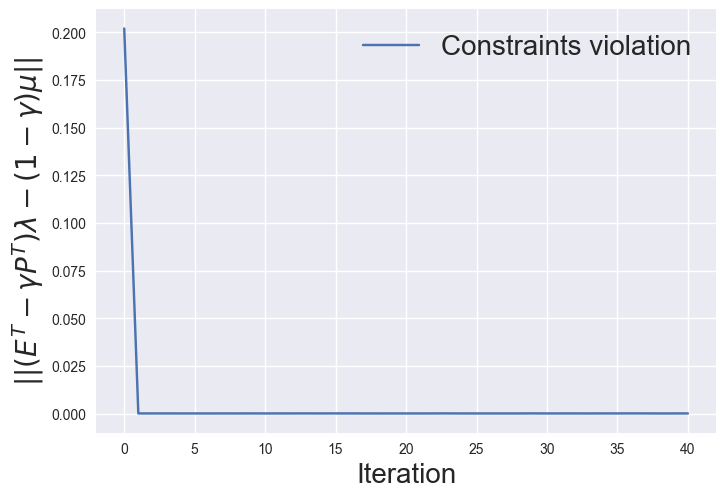

In [25]:
plot_lines([np.array(feasibility_errors)], [r"Constraints violation"], ["Iteration", "$|| (E^T - \gamma P^T)\lambda - (1 - \gamma) \mu ||$"], "figs", "constraints.pdf", show = True)

**Question**

Empirically, is the value of $||(E^T - \gamma P^T)\lambda - (1 - \gamma) \mu || $ higher for high or low values of `maxiter`?

Explain why this is the case.

**Answer:**

Empirically, the constraint violation 
$$
\| (E^T - \gamma P^T)\lambda - (1-\gamma)\mu \|
$$ 
is higher for low values of `maxiter`. This is because with fewer iterations, the inner minimization does not converge sufficiently, so the constraints are enforced only approximately. With a higher `maxiter`, the inner optimization converges more completely, leading to a lower constraint violation.

**Question:**

Strictly speaking, are the actual iterates $\lambda_k$ in the implementation above valid occupancy measures? In other words, is $E^T \lambda_k = \gamma P^T \lambda_k + (1 - \gamma) \mu$ strictly satisfied for all iterates? Explain why this is (not) the case.

**Answer:**

Strictly speaking, the iterates $\lambda_k$ in the implementation are not guaranteed to be valid occupancy measures; that is, the equality 
$$
E^T \lambda_k = \gamma P^T \lambda_k + (1-\gamma)\mu
$$ 
is not satisfied exactly at every iteration. This occurs because the updates are performed approximately (via gradient descent ascent with a finite number of iterations), so the constraints are only enforced up to numerical and optimization errors. Only in the limit of full convergence would the iterates satisfy the occupancy measure equality exactly.

**Plot of the suboptimality of the policies extracted from the $\lambda^k$'s**

*Extract the policies from the $\lambda^k$-iterates:* $$\pi_{\lambda^k}(a |s) = \frac{\lambda_k(s,a)} {\sum_{a\in\mathcal{A}}\lambda_k(s,a)}.$$

In [26]:
def extract_policies_from_occ_measures(occ_measures): # extract the policies from the occupancy measures
    policies = []
    for occ_measure in occ_measures:
        policy = np.zeros((gridworld.n_states, gridworld.n_actions)) # initialize the policy
        occ_measure = occ_measure.reshape(gridworld.n_states, -1) # reshape the occupancy measure
        states_occ_measure = occ_measure.sum(axis=1) # compute the occupancy measure over states (not state-action pairs)
        for s in range(gridworld.n_states):
            policy[s] = occ_measure[s] / occ_measure[s].sum() # compute the policy
        policies.append(policy)
        
    return policies

In [27]:
policies = extract_policies_from_occ_measures(iterates)

*Extract the occupancy measures from the policies:* $$ \lambda_{\pi_{\lambda^k}}(s,a) = (1 - \gamma)\sum^{\infty}_{t=0} \gamma^t \mathbb{P}[s_t=s,a_t=a | s_0 \sim \mu, \pi_{\lambda^k}].$$

In [28]:
def extract_occ_measures_from_policies(policies): # extract the occupancy measures from the policies (we do not require you to follow this)
    occ_measures = []
    for policy in policies:
        v = - (1 - gridworld.gamma)*(mu.repeat(gridworld.n_actions,axis=1)*policy).reshape(gridworld.n_states*gridworld.n_actions)
        matrix = np.eye(gridworld.n_states*gridworld.n_actions)
        T_pi = np.expand_dims(gridworld.T.transpose((1,0,2)),axis=3).repeat(gridworld.n_actions, axis=3)
        pi_tensor = np.expand_dims(policy, axis=(0,1)).repeat(T_pi.shape[0], axis=0).repeat(T_pi.shape[1], axis=1)
        T_pi = T_pi*pi_tensor
        matrix = gridworld.gamma*T_pi.reshape(gridworld.n_states*gridworld.n_actions,gridworld.n_states*gridworld.n_actions)- matrix
        occ_measure = np.linalg.solve(matrix.T, v)
        occ_measures.append(occ_measure)
    return occ_measures

In [29]:
occ_measures = extract_occ_measures_from_policies(policies)

*Check whether $\lambda_{\pi_{\lambda_k}} = \lambda_k$*:

In [30]:
# compute the difference between the occupancy measures and the iterates
diff_occ_measures = [np.linalg.norm(occ_measure - iterate) for occ_measure, iterate in zip(occ_measures, iterates)] 

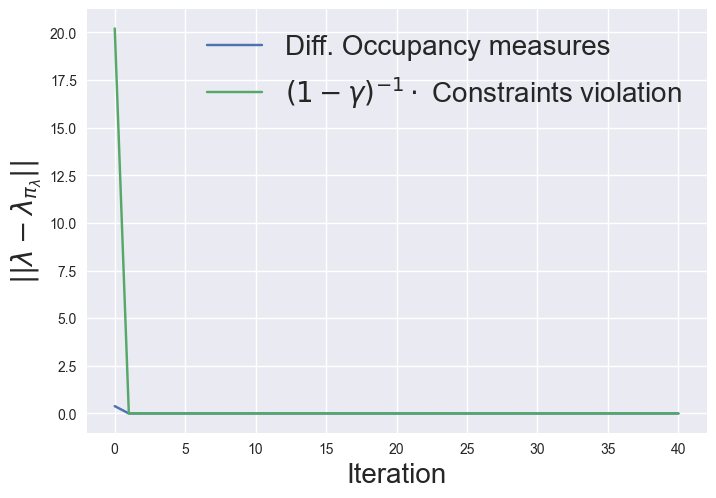

In [31]:
# plot the difference between the occupancy measures and the iterates
plot_lines([np.array(diff_occ_measures), np.array(feasibility_errors)/(1 - gridworld.gamma)], [r"Diff. Occupancy measures", r"$(1-\gamma)^{-1}\cdot$ Constraints violation"], ["Iteration", "$|| \lambda - \lambda_{\pi_\lambda}||$"], "figs", "diff_occ_measures.pdf", show = True)

**Questions**

- How does the norm of the difference $|| \lambda^k - \lambda_{\pi_{\lambda^k}}||$ relate to the constraint violation $|| (E^T - \gamma P^T)\lambda^k - (1 - \gamma) \mu ||$ ?

- If $|| (E^T - \gamma P^T)\lambda^k - (1 - \gamma) \mu ||$ is small, can you conclude that $|| \lambda^k - \lambda_{\pi_{\lambda^k}}||$ is also small ? 

*Hint: For both, you can answer leveraging the result in Lemma 3 of https://arxiv.org/pdf/2112.14004.pdf*

- As a consequence how is $|| \lambda^k - \lambda_{\pi_{\lambda^k}}||$ affected by the value of `maxiter`?

*Hint:* Recall your empirical finding about the impact of `maxiter` (above).

***Answer:***

- By Lemma 3 in the referenced paper, if the constraint violation is small, then $\lambda^k$ is close to a valid occupancy measure, and hence $\|\lambda^k - \lambda_{\pi_{\lambda^k}}\|$ is also small. In other words, these two quantities are tightly coupled.

- Yes, typically a small constraint violation implies that $\lambda^k$ is nearly a feasible occupancy measure, so it must be close to the “true” occupancy measure $\lambda_{\pi_{\lambda^k}}$ of its own induced policy. Thus, $\|\lambda^k - \lambda_{\pi_{\lambda^k}}\|$ is also small.

- As `maxiter` increases, each REPS update converges more precisely, reducing the constraint violation and thereby shrinking $\|\lambda^k - \lambda_{\pi_{\lambda^k}}\|$. In practice, larger `maxiter` leads to more accurate solutions and smaller differences.

**Evaluate the extracted policies**

In this section, we compute the value functions of the extracted policies which is $V^{\pi_{\lambda^k}}$

In [32]:
def evaluate_policy_sequence(policies, env, tol=1e-10):
    values = []
    for pi in policies:
        v = np.zeros(env.n_states) # initialize value function
        q = np.zeros((env.n_states, env.n_actions)) #initialize Q-value
        while True:
            v_old = np.copy(v) # save a copy of value function for the convergence criterion at the step
            for a in range(env.n_actions):
                q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v) #calculate Q-value
            for s in range(env.n_states):
                v[s] = pi[s].dot(q[s]) #calculate value function by $v(s) = max_a Q(s,a)$
            if np.linalg.norm(v - v_old) < tol: # convergence criterion
                break
        values.append(v)
    return values

In [33]:
def check_correctness(policies):
    values = evaluate_policy_sequence(policies, gridworld) # evaluate the policies
    for policy,v in zip(policies,values):
        state_occ_measure = solver.mu_policy(policy, stochastic=True) # compute the state occupancy measure
        occ_measure = np.expand_dims(state_occ_measure, axis=1).repeat(gridworld.n_actions, axis=1)*policy
        primal = occ_measure.reshape(gridworld.n_states*gridworld.n_actions).dot(gridworld.r.reshape(gridworld.n_states*gridworld.n_actions)) # compute the primal value
        dual = (1 - gridworld.gamma)*mu.T.dot(v) # compute the dual value
        assert primal - dual < 1e-7
    return [ (1 - gridworld.gamma)*mu.T.dot(v) for v in values] # return the values

**Question**

Do you expect $(1 - \gamma)\langle \mu, V^{\pi_{\lambda^k}} \rangle$ to be (approximately) equal to or (very) different from $\langle \lambda^k, r \rangle $? Does the answer depend on the value of `maxiter`?

*Hint: Recall that $(1 - \gamma)\langle \mu, V^{\pi_{\lambda^k}} \rangle = \langle \lambda_{\pi_{\lambda^k}}, r \rangle $ and argue using your previous answer concerning the term $|| \lambda^k - \lambda_{\pi_{\lambda^k}}||$.*

**Answer:**

Because $(1 - \gamma)\langle \mu, V^{\pi_{\lambda^k}} \rangle = \langle \lambda_{\pi_{\lambda^k}}, r \rangle$, these two quantities will be close **if** $\lambda^k$ is close to $\lambda_{\pi_{\lambda^k}}$. When the constraint violation is small (which happens more reliably for higher `maxiter`), we have $\lambda^k \approx \lambda_{\pi_{\lambda^k}}$, so $\langle \lambda^k, r \rangle \approx \langle \lambda_{\pi_{\lambda^k}}, r \rangle$. Conversely, for lower `maxiter` (and hence larger constraint violation), the difference can be larger, and the two values may deviate more significantly.

In [34]:
policy_values = check_correctness(policies) # check that $(1 - \gamma)\langle \mu, V^{\pi} \rangle = \langle \lambda_{\pi}, r \rangle $ for all policies.
policy_subopts = (1 - gridworld.gamma)*mu.T.dot(solver.v) - policy_values # compute the suboptimality of the policies

**Plot the suboptimalities**

Plot $(1 - \gamma)\langle \mu, V^{\pi^\star}\rangle - (1 - \gamma)\langle \mu, V^{\pi_{\lambda^k}} \rangle$.

Plot $(1 - \gamma)\langle \mu, V^{\pi^\star}\rangle - \langle \lambda^k, r \rangle$.

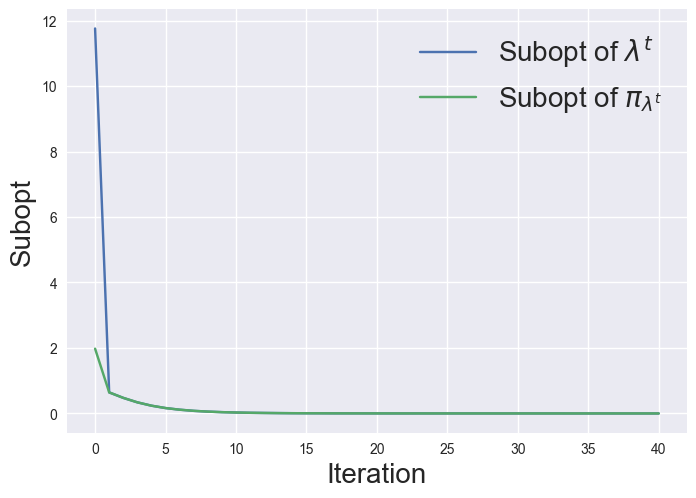

In [35]:
plot_lines([np.array(subopts), policy_subopts.flatten()], [r"Subopt of $\lambda^t$", r"Subopt of $\pi_{\lambda^t}$"], ["Iteration", "Subopt"], "figs", "subopts.pdf", show = True)

## Ex 4: Lagrangian methods [ 20 points ]

In this section we compute an optimal policy finding a saddle point of the Lagrangian $\mathcal{L}(\lambda, V)$, defined as follows

$$
\mathcal{L}(\lambda, V) = \langle \lambda, r \rangle + \langle (1 - \gamma) \mu + \gamma P^T \lambda - E^T \lambda, V \rangle .
$$

Finding a saddle point of the Lagrangian means solving the following problem:

$$ 
\mathrm{argmax}_{\lambda \geq 0} \min_{V \in \mathbb{R}^{|\mathcal{S}|}} \mathcal{L}(\lambda, V).
$$

By slide 6 in Lecture 3 it should be clear that there exists a saddle point pair $\lambda^\star, V^\star$ such that $|| V^\star ||_{\infty} \leq \frac{\max_{s,a} |r(s,a)|}{1 - \gamma}$. Therefore, we can consider looking for a saddle point over a restricted domain $\mathcal{V} = \{ V : ||V||_{\infty} \leq \frac{\max_{s,a} |r(s,a)|}{1 - \gamma} \}$:

$$ 
\mathrm{argmax}_{\lambda \geq 0} \min_{V \in \mathcal{V}} \mathcal{L}(\lambda, V).
$$

At this point we solve this problem with gradient descent ascent updates 

$$
\lambda^{k+1} \propto \lambda^k \odot \exp(\eta_{\lambda} \nabla_{\lambda} \mathcal{L}(\lambda^k, V^k)),
$$

$$
V^{k+1} = \Pi_{\mathcal{V}}[V^k - \eta_V \nabla_{V} \mathcal{L}(\lambda^k, V^k)].
$$

**Question**: 

Compute the following gradients:

$$  \nabla_{\lambda} \mathcal{L}(\lambda^k, V^k) = r + \gamma P\,V^k - E\,V^k. $$

$$ \nabla_{V} \mathcal{L}(\lambda^k, V^k) = (1-\gamma)\mu + \gamma P^T\lambda^k - E^T\lambda^k. $$

**Question:**

Which of the following conditions ensure that the policy $$\pi_{\lambda^k}(a |s) = \frac{\lambda_k(s,a)} {\sum_{a\in\mathcal{A}}\lambda^k(s,a)}$$ is $\epsilon$-suboptimal ?

(a) $$\langle \lambda^\star, r \rangle - \langle \lambda^k, r \rangle \leq \epsilon.$$
(b) $$(1 - \gamma)\langle \mu, V^\star \rangle - \langle \mu, V^k \rangle \leq \epsilon.$$
(c) $$ \mathcal{L}(\lambda^\star, V^k) - \mathcal{L}(\lambda^k, V^{\pi^{\lambda^k}}) \leq \epsilon.$$

Answer (a),(b) or (c).

**Answer**

The correct choice that implies $\epsilon$-suboptimality of 
$$
\pi_{\lambda^k}(a\,|\,s)=\frac{\lambda^k(s,a)}{\sum_{a\in\mathcal{A}} \lambda^k(s,a)}
$$
is condition (c):
$$
\mathcal{L}(\lambda^\star, V^k) 
- 
\mathcal{L}(\lambda^k, V^{\pi_{\lambda^k}}) 
\le \epsilon.
$$

### * Question [20 points]

Prove that the answer you gave at the question above implies that the policy $$\pi_{\lambda_k}(a |s) = \frac{\lambda_k(s,a)} {\sum_{a\in\mathcal{A}}\lambda^k(s,a)}$$ is $\epsilon$-suboptimal.
*Recall:* A policy $\pi$ is $\epsilon$-suboptimal if $ (1 - \gamma)  \langle\mu , V^\star - V^{\pi} \rangle\leq \epsilon$

 **Answer**

We consider the Lagrangian
$$
\mathcal{L}(\lambda, V) 
\;=\; 
\langle \lambda,\;r\rangle 
\;+\; 
\bigl\langle (1-\gamma)\,\mu \;+\;\gamma\,P^T \lambda \;-\;E^T \lambda,\;V\bigr\rangle.
$$

Let $\lambda^\star$ be an optimal dual variable and $V^\star$ the optimal value function, satisfying 
$$
(1-\gamma)\,\langle \mu,\,V^\star\rangle 
\;=\; 
\langle \lambda^\star,\;r\rangle.
$$

We define the policy associated with $\lambda^k$ as
$$
\pi_{\lambda^k}(a \mid s)
\;=\;
\frac{\lambda^k(s,a)}{\sum_{a' \in \mathcal{A}}\lambda^k(s,a')},
$$
and its value function is $V^{\pi_{\lambda^k}}$.

---

## 1. Why condition (c) implies $\epsilon$-suboptimality

Condition (c) states
$$
\mathcal{L}(\lambda^\star, V^k)
\;-\;
\mathcal{L}(\lambda^k, V^{\pi_{\lambda^k}})
\;\le\;
\epsilon.
$$

1. If $\lambda^\star$ and $\lambda^k$ are feasible (i.e., they satisfy 
   $(1-\gamma)\,\mu + \gamma\,P^T\lambda^\star - E^T\lambda^\star = 0$ and similarly for $\lambda^k$),  
   then
   $$
   \mathcal{L}(\lambda^\star, V^k)
   \;=\;
   \langle \lambda^\star,\;r\rangle,
   \quad
   \mathcal{L}(\lambda^k, V^{\pi_{\lambda^k}})
   \;=\;
   \langle \lambda^k,\;r\rangle.
   $$

2. **Relation to value functions.**  
   When $\lambda^k$ is the occupancy measure of $\pi_{\lambda^k}$, we have
   $$
   \langle \lambda^k,\;r\rangle 
   \;=\;
   (1-\gamma)\,\langle \mu,\;V^{\pi_{\lambda^k}}\rangle,
   \quad
   \langle \lambda^\star,\;r\rangle 
   \;=\;
   (1-\gamma)\,\langle \mu,\;V^\star\rangle.
   $$

3. Putting this together:
   $$
   \mathcal{L}(\lambda^\star, V^k)
   \;-\;
   \mathcal{L}(\lambda^k, V^{\pi_{\lambda^k}})
   \;=\;
   (1-\gamma)\,\langle \mu,\;V^\star\rangle 
   \;-\;
   (1-\gamma)\,\langle \mu,\;V^{\pi_{\lambda^k}}\rangle
   \;=\;
   (1-\gamma)\,\bigl\langle \mu,\;V^\star - V^{\pi_{\lambda^k}}\bigr\rangle.
   $$

   Hence condition (c) becomes
   $$
   (1-\gamma)\,\bigl\langle \mu,\;V^\star - V^{\pi_{\lambda^k}}\bigr\rangle
   \;\le\;
   \epsilon,
   $$
   which is exactly the definition that $\pi_{\lambda^k}$ is $\epsilon$-suboptimal.

---

## 2. Why (a) and (b) do **not** imply $\epsilon$-suboptimality

We compare to the statements:

- (a) $\langle \lambda^\star, r\rangle - \langle \lambda^k, r\rangle \le \epsilon$,
- (b) $(1-\gamma)\,\langle \mu, V^\star\rangle - \langle \mu, V^k\rangle \le \epsilon$.

Neither (a) nor (b) guarantees the exact difference $(1-\gamma)\langle \mu, V^\star - V^{\pi_{\lambda^k}}\rangle$ is small. In particular:

1. (a) only involves the dual variables $\lambda^\star, \lambda^k$ and the reward $r$. It does **not** necessarily reflect the value of the specific policy $\pi_{\lambda^k}$ unless we assume $\lambda^k$ is precisely the occupancy measure for that policy.
2. (b) compares $(1-\gamma)\langle \mu, V^\star\rangle$ and $\langle \mu, V^k\rangle$, but $V^k$ is just the variable in the Lagrangian updates (a "dual" or "auxiliary" value), not necessarily $V^{\pi_{\lambda^k}}$. Therefore, bounding the difference with $V^k$ does not imply the difference with $V^{\pi_{\lambda^k}}$ is small.

Only condition (c) links everything together (reward terms, dual feasibility, and the actual policy's value) to ensure $\epsilon$-suboptimality.

---

# Conclusion

- (c) $\mathcal{L}(\lambda^\star, V^k) - \mathcal{L}(\lambda^k, V^{\pi_{\lambda^k}}) \le \epsilon$ is the condition that implies $(1-\gamma)\langle \mu, V^\star - V^{\pi_{\lambda^k}}\rangle \le \epsilon$. Hence, $\pi_{\lambda^k}$ is indeed $\epsilon$-suboptimal.
- Conditions (a) and (b) alone do not imply the needed performance guarantee on $V^{\pi_{\lambda^k}}$.